Will use device: cpu, torch dtype: torch.float32


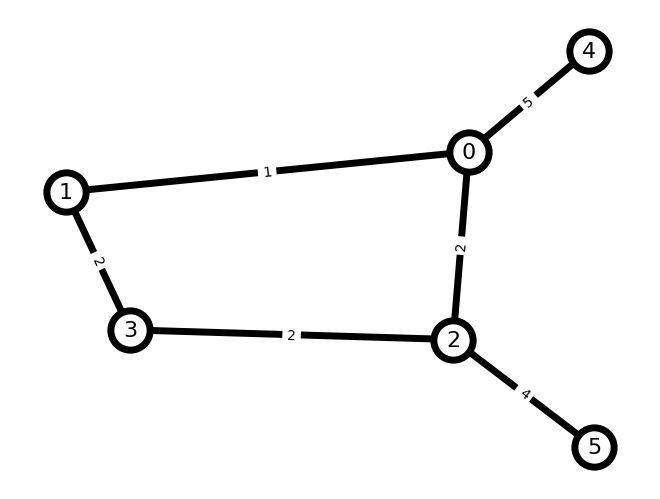

In [1]:
from GraphCreator import *

In [2]:
def gen_adj_matrix(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight']
        adj_dict[(v, u)] = nx_G[u][v]['weight']

    for u in nx_G.nodes:
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0

    return adj_dict

def DrawGraph(graph):
    pos = nx.spring_layout(graph,seed=1)

    # Visualize graph
    options = {
        "font_size": 16,
        "node_size": 800,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 5,
        "width": 5,
    }
    nx.draw(graph, pos, with_labels=True, **options)

    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat

def calculateMinCut(adj_matrix, output, terminal1 = 0, terminal2 = 4):
    #output = (output.detach() >= 0.5) * 1

    # if output[terminal1] == output[terminal2]:
    #     return float("inf")
    #print(adj_matrix, output)
    loss = 0
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if (output[i] > 0.5 and output[j] < 0.5) or (output[i] < 0.5 and output[j] > 0.5) :
                loss+=adj_matrix[i][j]

    return loss

def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * partition_matrix).sum() / 2
    return weight

def expected_partition_weight(adj, s):
    """
    Calculates the expected sum of weights of edges that are in different partitions,
    based on the probabilities in s.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the probability of each edge being in a certain partition.
    :return: Expected sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.outer(s, 1 - s) + np.outer(1 - s, s)
    expected_weight = (adj * partition_matrix).sum() / 2
    return expected_weight

# Hamiltonian Partitioning
We are going to experiment with hamilotnian paritioning on couple of graphs and adjacent matrix to see how well it works

In [3]:
def Hamiltonian(s, w, A = 1, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    #HA = ((s.sum() ** 2) if len(s) % 2 == 0 else ((s.sum() ** 2) / 2))
    HA = ((np.sum(s)** 2) if len(s) % 2 == 0 else ((np.sum(s) ** 2) / 2))

    # Calculate HB
    # HB = np.sum(w * (1 - np.outer(s, s)) / 2)

    HB = (w * (1 - np.outer(s, s)) / 2).sum()
    # Hamiltonian H
    H = A * HA + B * HB

    return H

def HamiltonianLoss(s, w, A = 1, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    HA = ((s.sum() ** 2) if len(s) % 2 == 0 else ((s.sum() ** 2) / 2))

    # Calculate HB
    # HB = np.sum(w * (1 - np.outer(s, s)) / 2)

    HB = (w * (1 - torch.outer(s, s)) / 2).sum()
    # Hamiltonian H
    H = A * HA + B * HB

    return H

def HamiltonianLoss2(s, w, A = 9, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    num_nodes = s.size(0)
    ideal_balance = num_nodes / 2.0

    # HA is a penalty term for the deviation of sum of probabilities from the ideal balance
    HA = (torch.sum(s) - ideal_balance) ** 2

    # Calculate HB
    # HB = np.sum(w * (1 - np.outer(s, s)) / 2)

    HB = (w * (1 - torch.outer(s, s)) / 2).sum()
    # Hamiltonian H
    H = A * HA + B * HB

    return H


def HamiltonianLoss3(s, w, A = 1, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    num_nodes = s.size(0)
    ideal_balance = num_nodes / 2.0

    # HA is a penalty term for the deviation of sum of probabilities from the ideal balance
    HA = (torch.sum(s) - ideal_balance) ** 2

    HB = expected_partition_weight2(w, s)
    # Hamiltonian H
    H = A * HA + B * HB

    return H

def expected_partition_weight2(adj, s):
    """
    Calculates the expected sum of weights of edges that are in different partitions,
    based on the probabilities in s.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the probability of each edge being in a certain partition.
    :return: Expected sum of weights of edges in different partitions.
    """
    #s = torch.array(s)
    partition_matrix = torch.outer(s, 1 - s) + torch.outer(1 - s, s)
    expected_weight = (adj * partition_matrix).sum() / 2

    # # Penalty term
    # edge_probs = s[list((0,4))]
    # penalty = 10 * torch.prod(edge_probs) + 10 * torch.prod(1 - edge_probs)
    # expected_weight += penalty
    return expected_weight

# Generic Partition formula

Formula for generic partition


In [4]:
import numpy as np

# Function to calculate HA
def calculate_HA(s):
    # HA = ∑v∈V(∑k=1K(sv,k−1))^2
    HA = sum((s[v].sum() - 1) ** 2 for v in range(len(s)))
    return HA

# Function to calculate HB
def calculate_HB(s, V):
    # HB = ∑k=1K(∑v∈V(sv,k−|V|/K))^2
    K = len(s[0])
    HB = sum((s[:, k].sum() - V / K) ** 2 for k in range(K))
    return HB

# Function to calculate HC
def calculate_HC(s, graph):
    # HC = ∑(u,v)∈E∑k=1K(1−su,k∗sv,k)
    K = len(s[0])
    HC = sum(graph[u, v] * (1 - sum(s[u, k] * s[v, k] for k in range(K)))
             for u in range(len(graph)) for v in range(len(graph)) if u != v)
    return HC

# Example input
s = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])  # partition matrix
graph = np.array([[0, 1, 1, 0],  # adjacency matrix
                  [1, 0, 0, 1],
                  [1, 0, 0, 0],
                  [0, 1, 0, 0]])

# Number of vertices
V = s.shape[0]

# Calculate HA, HB, HC
HA = calculate_HA(s)
HB = calculate_HB(s, V)
HC = calculate_HC(s, graph)

HA, HB, HC


(0, 0.0, 6)

## Vectorized form for partition

In [88]:
# Vectorized form of the calculations for HA, HB, and HC

def calculate_HA_vectorized(s):
    """
    Vectorized calculation of HA.
    :param s: A binary matrix of size |V| x |K| where s[i][j] is 1 if vertex i is in partition j.
    :return: The HA value.
    """
    # HA = ∑v∈V(∑k∈K(sv,k)−1)^2
    HA = torch.sum((torch.sum(s, axis=1) - 1) ** 2)
    return HA

def calculate_HB_vectorized(s, V, K):
    """
    Vectorized calculation of HB.
    :param s: A binary matrix of size |V| x |K|.
    :param V: The number of vertices.
    :param K: The number of partitions.
    :return: The HB value.
    """
    # HB = ∑k∈K(∑v∈V(sv,k)−|V|/K)^2
    average_partition_size = V / K
    HB = torch.sum((torch.sum(s, axis=0) - average_partition_size) ** 2)
    return HB

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Vectorized calculation of HC.
    :param s: A binary matrix of size |V| x |K|.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # HC = ∑(u,v)∈E(1−∑k∈K(su,k*sv,k))*adjacency_matrix[u,v]
    K = s.shape[1]
    # Outer product to find pairs of vertices in the same partition and then weight by the adjacency matrix
    prod = adjacency_matrix * (1 - s @ s.T)
    HC = torch.sum(prod)
    return HC

def calculate_H(s, adjacency_matrix, A = 12, B = 1, C = 1):
    V = s.shape[0]  # Total vertices
    K = s.shape[1]  # Total partitions
    HA_vectorized = calculate_HA_vectorized(s)
    HB_vectorized = calculate_HB_vectorized(s, V, K)
    HC_vectorized = calculate_HC_vectorized(s, adjacency_matrix)

    return A*HA_vectorized + B*HB_vectorized + C*HC_vectorized




In [7]:
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions
s = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])  # partition matrix
adjacency_matrix = np.array([[0, 1, 1, 0],  # adjacency matrix
                             [1, 0, 0, 1],
                             [1, 0, 0, 0],
                             [0, 1, 0, 0]])
# Example usage with the same s and adjacency_matrix as before
HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, adjacency_matrix)

HA_vectorized, HB_vectorized, HC_vectorized

TypeError: sum(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

# Graph 1 experiments
## Experiment with H partitiioning

We are going to run H paritioning on some graphs with different s values. Lets talk our first graph:

Vertex 0 --(1)-- Vertex 1
  |     \
  |       \
 (3)      (2)
  |          \
  |            \
Vertex 2 --(1)-- Vertex 3



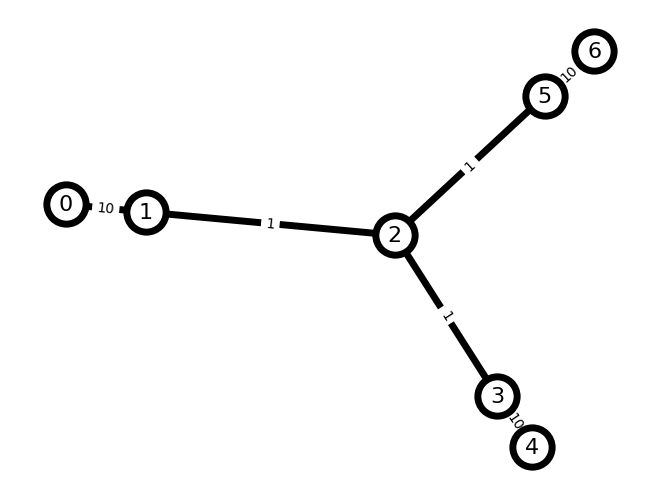

In [72]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (2,5, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
DrawGraph(graph)

In [73]:
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
q_torch

tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., 10.],
        [ 0.,  0.,  0.,  0.,  0., 10.,  0.]])

In [74]:

s = torch.from_numpy(np.array([[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0,0, 1]]) ) # partition matrix
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_H(s, q_torch))

s = torch.from_numpy(np.array([[1, 0, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0,0, 1]]))  # partition matrix
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_H(s, q_torch))

s = torch.from_numpy(np.array([[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0,1, 0]]))  # partition matrix
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_H(s, q_torch))

s = torch.from_numpy(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1,1, 1]]) ) # partition matrix)
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_H(s, q_torch))



s = torch.from_numpy(np.array([[0, 0, 1],
                               [0, 0, 1],
                               [1, 1, 0],
                               [0, 0, 1],
                               [0, 0, 1],
                               [1, 1, 0],
                               [1, 1, 0]]) ) # partition matrix)
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_H(s, q_torch))


tensor(0) tensor(0.6667) tensor(4.) tensor(4.6667) tensor(4.) tensor(4.6667)
tensor(1) tensor(1.0000) tensor(2.) tensor(4.) tensor(4.) tensor(23.)
tensor(0) tensor(4.6667) tensor(24.) tensor(28.6667) tensor(24.) tensor(28.6667)
tensor(28) tensor(65.3333) tensor(-132.) tensor(-38.6667) tensor(-76.) tensor(493.3334)
tensor(3) tensor(3.6667) tensor(-18.) tensor(-11.3333) tensor(-12.) tensor(45.6667)


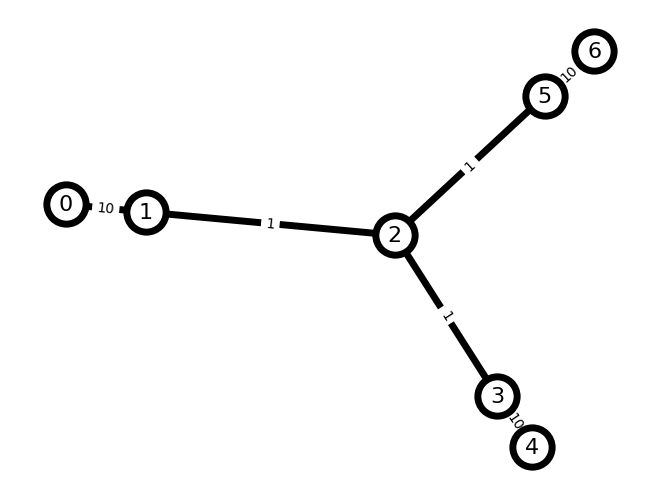

In [75]:
DrawGraph(graph)

# Using k-parition formula, adding regularization to it

We want to add regularization to ensure a edge goes closer to 0 or 1

In [76]:


def calculate_regularization_term(s, gamma):
    return gamma * torch.sum(s * (1 - s))

def calculate_H_prime(s, adjacency_matrix,  gamma = 1, A = 20, B = 1, C = 1):
    V = s.shape[0]  # Total vertices
    K = s.shape[1]  # Total partitions
    HA = calculate_HA_vectorized(s)
    HB = calculate_HB_vectorized(s, V, K)
    HC = calculate_HC_vectorized(s, adjacency_matrix)
    R = calculate_regularization_term(s, gamma)
    return A*HA + B*HB + C*HC + R

In [77]:

s = torch.from_numpy(np.array([[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0,0, 1]]) ) # partition matrix
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)
calculate_regularization_term(s, gamma = 1)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_regularization_term(s, gamma = 1), calculate_H(s, q_torch), calculate_H_prime(s, q_torch))

s = torch.from_numpy(np.array([[1, 0, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0,0, 1]]))  # partition matrix
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)
calculate_regularization_term(s, gamma = 1)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_regularization_term(s, gamma = 1), calculate_H(s, q_torch), calculate_H_prime(s, q_torch))

s = torch.from_numpy(np.array([[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0,1, 0]]))  # partition matrix
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)
calculate_regularization_term(s, gamma = 1)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_regularization_term(s, gamma = 1), calculate_H(s, q_torch), calculate_H_prime(s, q_torch))

s = torch.from_numpy(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1,1, 1]]) ) # partition matrix)
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)
calculate_regularization_term(s, gamma = 1)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_regularization_term(s, gamma = 1), calculate_H(s, q_torch), calculate_H_prime(s, q_torch))



s = torch.from_numpy(np.array([[0, 0, 1],
                               [0, 0, 1],
                               [1, 1, 0],
                               [0, 0, 1],
                               [0, 0, 1],
                               [1, 1, 0],
                               [1, 1, 0]]) ) # partition matrix)
V = s.shape[0]  # Total vertices
K = s.shape[1]  # Total partitions

HA_vectorized = calculate_HA_vectorized(s)
HB_vectorized = calculate_HB_vectorized(s, V, K)
HC_vectorized = calculate_HC_vectorized(s, q_torch)
calculate_regularization_term(s, gamma = 1)

print(HA_vectorized, HB_vectorized, HC_vectorized, HA_vectorized+ HB_vectorized + HC_vectorized, 2*HA_vectorized+  HC_vectorized, calculate_regularization_term(s, gamma = 1), calculate_H(s, q_torch), calculate_H_prime(s, q_torch))

tensor(0) tensor(0.6667) tensor(4.) tensor(4.6667) tensor(4.) tensor(0) tensor(4.6667) tensor(4.6667)
tensor(1) tensor(1.0000) tensor(2.) tensor(4.) tensor(4.) tensor(0) tensor(23.) tensor(23.)
tensor(0) tensor(4.6667) tensor(24.) tensor(28.6667) tensor(24.) tensor(0) tensor(28.6667) tensor(28.6667)
tensor(28) tensor(65.3333) tensor(-132.) tensor(-38.6667) tensor(-76.) tensor(0) tensor(493.3334) tensor(493.3334)
tensor(3) tensor(3.6667) tensor(-18.) tensor(-11.3333) tensor(-12.) tensor(0) tensor(45.6667) tensor(45.6667)


# Classic 3-way multicut algorithm


In [37]:

def three_way_min_cut(G, A, B, C):
    # Step 1: Find min cut between A and B
    cut_value_AB, partition_AB = nx.minimum_cut(G, A, B)
    reachable, non_reachable = partition_AB
    cutset_AB = nx.edge_boundary(G, reachable, non_reachable)

    # Step 2: Merge A and B into a super-node and find min cut with C
    # First, create a copy of the graph to modify
    G_copy = G.copy()
    # Merge A and B into a super-node (by contracting A into B)
    G_copy = nx.contracted_nodes(G_copy, B, A, self_loops=False)

    # Step 3: Find min cut between super-node (B) and C
    cut_value_BC, partition_BC = nx.minimum_cut(G_copy, B, C)
    reachable, non_reachable = partition_BC
    cutset_BC = nx.edge_boundary(G_copy, reachable, non_reachable)

    # Translate the cutset back to the original nodes, if necessary
    cutset_BC_translated = set()
    for u, v in cutset_BC:
        if u == B:
            u = A
        if v == B:
            v = A
        cutset_BC_translated.add((u, v))

    # Combine the two cutsets
    total_cutset = cutset_AB.union(cutset_BC_translated)

    return total_cutset

A = (1, 3)
B = (1, 5)
C = (3, 5)

cutset = three_way_min_cut(graph_dgl,  A, B, C)
print("3-way min cut edges:", cutset)

DGLError: Invalid key "0". Must be one of the edge types.

# Neural Network Code

Neural Network Architecture

In [13]:
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)



        return h

In [14]:
# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

In [89]:
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, loss_func):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    #best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_bitstring = torch.zeros(7,3).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)  # collapse extra dimension output from model

        # build cost value with QUBO cost function
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        #calc = partition_weight(q_torch, bitstring)
        if loss < best_loss:
            best_loss = loss
            best_bitstring = bitstring

        # if calc < best_loss and calc != 0:
        #     best_loss = loss
        #     best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')
            print(probs, q_torch)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring
def run_gnn_training2(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, loss_func):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model

        # build cost value with QUBO cost function
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        calc = partition_weight(q_torch, bitstring)
        # if loss < best_loss:
        #     best_loss = loss
        #     best_bitstring = bitstring
        #add reward
        loss = loss-calc

        if calc < best_loss and calc != 0:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')
            print(probs, q_torch)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring

In [90]:
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = int(np.sqrt(n))    # e.g. 10
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

# Training GCN on graph 2

In [91]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (2,5, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=10000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [92]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], calculate_H)
final_bitstring, best_bitstring

Running GNN...
Epoch: 0, Loss: 42.83835983276367
tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5219, 0.4701, 0.5370],
        [0.5000, 0.5000, 0.5000],
        [0.5379, 0.4483, 0.5638],
        [0.5910, 0.3771, 0.6505],
        [0.5000, 0.5000, 0.5000]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., 10.],
        [ 0.,  0.,  0.,  0.,  0., 10.,  0.]])
Epoch: 1000, Loss: 39.86567687988281
tensor([[0.4772, 0.4772, 0.4772],
        [0.4772, 0.4772, 0.4772],
        [0.4810, 0.4710, 0.4839],
        [0.4772, 0.4772, 0.4772],
        [0.4838, 0.4664, 0.4888],
        [0.5347, 0.3839, 0.5785],
        [0.4772, 0.4772, 0.4772]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0., 

(tensor([[0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1]]),
 tensor([[0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1]]))

In [104]:
final_bitstring, best_bitstring

(tensor([[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]),
 [[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]])

In [69]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (2,5, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=10000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)
_, epoch, final_bitstring1, best_bitstring1 = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], calculate_H_prime)
final_bitstring1, best_bitstring1

Epoch: 0, Loss: 38.458824157714844
tensor([[0.5000, 0.5000, 0.5000],
        [0.4798, 0.4288, 0.4591],
        [0.4996, 0.4987, 0.4993],
        [0.4982, 0.4935, 0.4963],
        [0.5000, 0.5000, 0.5000],
        [0.4982, 0.4935, 0.4963],
        [0.4994, 0.4978, 0.4987]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., 10.],
        [ 0.,  0.,  0.,  0.,  0., 10.,  0.]])
Epoch: 1000, Loss: 38.12750244140625
tensor([[0.5170, 0.5046, 0.5143],
        [0.5033, 0.4429, 0.4812],
        [0.5121, 0.4824, 0.5024],
        [0.5170, 0.5046, 0.5143],
        [0.5170, 0.5046, 0.5143],
        [0.5170, 0.5046, 0.5143],
        [0.5085, 0.4662, 0.4937]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0.,  1.,  0.,  0.,

(tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1]]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1]]))

In [70]:
final_bitstring1, best_bitstring1

(tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1]]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1],
         [0, 1, 1]]))

# Graph 2 Experiment

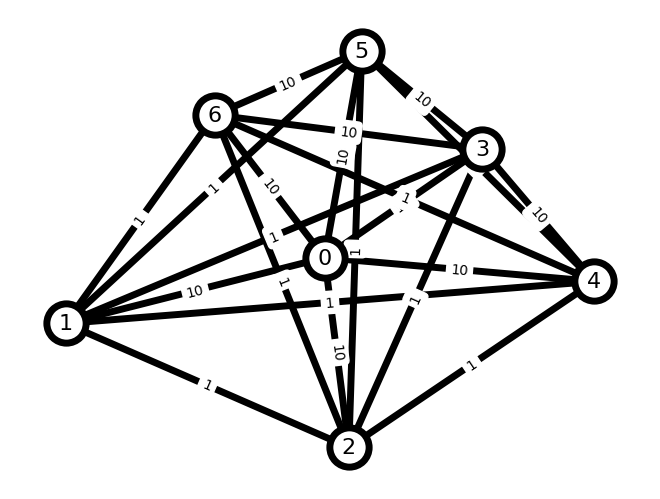

In [96]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (0,2, {"weight": 10, "capacity":10}),
         (0,3, {"weight": 10, "capacity":10}),
         (0,4, {"weight": 10, "capacity":10}),
         (0,5, {"weight": 10, "capacity":10}),
         (0,6, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (1,3, {"weight": 1, "capacity":1}),
         (1,4, {"weight": 1, "capacity":1}),
         (1,5, {"weight": 1, "capacity":1}),
         (1,6, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (2,4, {"weight": 1, "capacity":1}),
         (2,5, {"weight": 1, "capacity":1}),
         (2,6, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (3,5, {"weight": 10, "capacity":10}),
         (3,6, {"weight": 10, "capacity":10}),
         (4,5, {"weight": 1, "capacity":1}),
         (4,6, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
DrawGraph(graph)

In [97]:
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
q_torch

tensor([[ 0., 10., 10., 10., 10., 10., 10.],
        [10.,  0.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  0.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  0., 10., 10., 10.],
        [10.,  1.,  1., 10.,  0.,  1.,  1.],
        [10.,  1.,  1., 10.,  1.,  0., 10.],
        [10.,  1.,  1., 10.,  1., 10.,  0.]])

## Training GCN on graph 2

In [98]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (0,2, {"weight": 10, "capacity":10}),
         (0,3, {"weight": 10, "capacity":10}),
         (0,4, {"weight": 10, "capacity":10}),
         (0,5, {"weight": 10, "capacity":10}),
         (0,6, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (1,3, {"weight": 1, "capacity":1}),
         (1,4, {"weight": 1, "capacity":1}),
         (1,5, {"weight": 1, "capacity":1}),
         (1,6, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (2,4, {"weight": 1, "capacity":1}),
         (2,5, {"weight": 1, "capacity":1}),
         (2,6, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (3,5, {"weight": 10, "capacity":10}),
         (3,6, {"weight": 10, "capacity":10}),
         (4,5, {"weight": 1, "capacity":1}),
         (4,6, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=10000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [99]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], calculate_H)

calc = calculateMinCut(q_torch, best_bitstring)
gnn_time = time() - gnn_start
final_bitstring, best_bitstring

Running GNN...
Epoch: 0, Loss: 80.58333587646484
tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10., 10., 10., 10., 10., 10.],
        [10.,  0.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  0.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  0., 10., 10., 10.],
        [10.,  1.,  1., 10.,  0.,  1.,  1.],
        [10.,  1.,  1., 10.,  1.,  0., 10.],
        [10.,  1.,  1., 10.,  1., 10.,  0.]])
Epoch: 1000, Loss: 71.67942810058594
tensor([[0.5248, 0.5248, 0.5248],
        [0.5248, 0.5248, 0.5248],
        [0.5248, 0.5248, 0.5248],
        [0.5248, 0.5248, 0.5248],
        [0.5248, 0.5248, 0.5248],
        [0.5248, 0.5248, 0.5248],
        [0.5248, 0.5248, 0.5248]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10., 10., 10., 10., 10., 10.],
        [10.,  0., 

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [100]:
final_bitstring, best_bitstring

(tensor([[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]),
 tensor([[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]))

In [101]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (0,2, {"weight": 10, "capacity":10}),
         (0,3, {"weight": 10, "capacity":10}),
         (0,4, {"weight": 10, "capacity":10}),
         (0,5, {"weight": 10, "capacity":10}),
         (0,6, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (1,3, {"weight": 1, "capacity":1}),
         (1,4, {"weight": 1, "capacity":1}),
         (1,5, {"weight": 1, "capacity":1}),
         (1,6, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (2,4, {"weight": 1, "capacity":1}),
         (2,5, {"weight": 1, "capacity":1}),
         (2,6, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (3,5, {"weight": 10, "capacity":10}),
         (3,6, {"weight": 10, "capacity":10}),
         (4,5, {"weight": 1, "capacity":1}),
         (4,6, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=10000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)
_, epoch, final_bitstring1, best_bitstring1 = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], calculate_H_prime)
final_bitstring1, best_bitstring1

Epoch: 0, Loss: 99.2914047241211
tensor([[0.5235, 0.4812, 0.5002],
        [0.5239, 0.4808, 0.5002],
        [0.5267, 0.4786, 0.5003],
        [0.5301, 0.4759, 0.5003],
        [0.5268, 0.4785, 0.5003],
        [0.5264, 0.4788, 0.5003],
        [0.5233, 0.4814, 0.5002]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10., 10., 10., 10., 10., 10.],
        [10.,  0.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  0.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  0., 10., 10., 10.],
        [10.,  1.,  1., 10.,  0.,  1.,  1.],
        [10.,  1.,  1., 10.,  1.,  0., 10.],
        [10.,  1.,  1., 10.,  1., 10.,  0.]])
Epoch: 1000, Loss: 87.56524658203125
tensor([[0.6616, 0.4283, 0.5393],
        [0.6592, 0.4299, 0.5390],
        [0.6633, 0.4271, 0.5396],
        [0.6707, 0.4220, 0.5405],
        [0.6645, 0.4263, 0.5397],
        [0.6634, 0.4271, 0.5396],
        [0.6595, 0.4297, 0.5391]], grad_fn=<SigmoidBackward0>) tensor([[ 0., 10., 10., 10., 10., 10., 10.],
        [10.,  0.,  1.,  1.,  1.,  

(tensor([[1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1]]),
 tensor([[1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1]]))